In [1]:
import importlib, yaml
import os, pandas as pd, numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
from sod.core import pdconcat
import sod.core.evaluation as sod_core_eval
importlib.reload(sod_core_eval)
from sklearn.metrics import roc_curve
from itertools import cycle
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot

print('loading source testset')
allset_test = sod_core_dataset.open_dataset('allset_test.hdf', normalize=False, verbose=False)
print('Columns')
print(allset_test.columns.tolist())

# now plot classifiers:
@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

print()
print('DONE')

loading source testset
Columns
['allset_test.id', 'dataset_id', 'psd@0.05sec', 'psd@0.1sec', 'psd@0.2sec', 'psd@0.5sec', 'psd@1sec', 'psd@2sec', 'psd@3sec', 'psd@5sec', 'psd@9sec', 'outlier', 'subclass', 'window_type', 'amplitude_ratio', 'event_id', 'station_id', 'event_time', 'channel_code', 'magnitude', 'distance_km', 'location_code']

DONE


In [2]:
# Reading (creating) predictions on the test set instances

maindir = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/eval.allset_train_test.iforest.psd@5sec.n_estimators=75.yaml/'))
assert os.path.isdir(maindir)

# classifier names
names = [
    # 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=256&n_estimators=75',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=75',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=75',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=75',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=75',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=75',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=75',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=32768&n_estimators=75',
]
# check we did provide different file names:
assert len(set(names)) == len(names)


print('Reading the following classifiers (clf) with relative id (id: clf name):')
for i, n in enumerate(names):
    print('[%d]: %s' % (i, n))
clfs = [load(os.path.join(maindir, 'models', name+'.model')) for name in names]

print('Loading prediction dataframes')
maindir_preddf = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/eval.allset_train_test.iforest.psd@5sec.n_estimators=75.yaml/'))
assert os.path.isdir(maindir_preddf)
pred_dfs = [
    pd.read_hdf(os.path.join(_, 'predictions', name+'.hdf'))
    for _,name in zip(cycle([maindir_preddf]), names)
]


# Remove station with dataset_id = 2 and station_id=3258 (S1.AUTAR) as it was wrongly put in the validation set.
# CHECK!!
for i, pred_df in enumerate(pred_dfs):
    oldlen = len(pred_dfs[i])
    pred_dfs[i] = pred_df[(pred_df.dataset_id != 2) | (pred_df.station_id !=3258)].copy()
    assert len(pred_dfs[i]) == oldlen - 1325

classnames = sod_core_dataset.allset_test.classnames
classes = {_: sod_core_dataset.allset_test.class_selector[_] for _ in classnames}
assert len(classes) == 3

labels = [int(clf.max_samples) for clf in clfs]
# or: # [int(re.match('.*max_samples=(\d+).*', _).group(1)) for _ in names]

def get_pred_df(index, *classindices):
    # label can be either 0: validation set inliers, 1: validation set outliers, 2: test set
    _df_ = pred_dfs[index]
    if not classindices:
        return _df_
    selector = None
    for classindex in classindices:
        _selector = classes[classnames[classindex]](_df_)
        if selector is None:
            selector = _selector
        else:
            selector |= _selector 
    return _df_[selector] 

from sklearn.metrics import precision_recall_fscore_support, auc, roc_curve
def get_cm(y_true, y_pred):
    fpr, tpr, th = roc_curve(y_true, y_pred)
    # from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html:
    # thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1.
    fpr, tpr, th = fpr[1:], tpr[1:], th[1:]
    tnr = 1 - fpr
    fnr = 1 - tpr
    p = float(sum(y_true))
    tp = tpr * p
    fp = fpr * p
    # fnr = 1-tpr
    n = len(y_true) - p
    tn = tnr * n
    fn = fnr * n
    # ppv = tp / (tp + fp)
    
    # find best thresold:
    argmax = np.argmax((tnr + tpr))  # we should write 0.5 * (tnr+tpr) but fro finding the max it's the same 
    best_th = th[argmax]
    y_pred2 = np.zeros(len(y_true), dtype=int)
    y_pred2[y_pred>=best_th] = 1
    p, r, f, n = precision_recall_fscore_support(y_true, y_pred2, labels=[0, 1])

    cm = pd.DataFrame(index=['[0]', '[1]', 'Averages (sum for N):'],
                      columns=['cl.as[0]', 'cl.as[1]', 'N', 'R', 'P', 'F1'],
                      data=[
                          [int(r[0]*n[0]),          int(n[0] - (r[0]*n[0])), n[0], r[0], p[0], f[0]],
                          [int(n[1] - (r[1]*n[1])), int(r[1]*n[1]),          n[1], r[1], p[1], f[1]],
                          ['', '', np.sum(n), np.nanmean(r), np.nanmean(p), np.nanmean(f)]
                      ])
    return auc(fpr, tpr), best_th, cm
    
    

print('Setting scores with offset and normalization (columns score_samples_offset_only and score_samples)')
metrics_columns = ['ValSet auc', 'ValSet logloss_outliers', 'TestSet MSE']
metrics = pd.DataFrame(index=range(len(clfs)), columns=metrics_columns)

best_thresholds, maxima = [] , []
best_cm = {}

# setting stuff:
for idx, pred_df in enumerate(pred_dfs):
    pred_df['channel_code'] = pred_df['channel_code'].astype('category')
    pred_df['location_code'] = pred_df['location_code'].astype('category')
    pred_df['cha_id'] = pred_df['channel_code'].str[:2]
    pred_df['cha_id'] = pred_df['cha_id'].astype('category')
    
    # get best threhold, calcuated from validation set only (inliers + outliers, no Me unknown):
    pred_df_outl_inl_only = get_pred_df(idx, 0, 1)
#     fpr, tpr, th = roc_curve(pred_df_outl_inl_only.outlier, pred_df_outl_inl_only.predicted_anomaly_score)
#     tnr = 1-fpr
#     p = sum(pred_df_outl_inl_only.outlier)
#     tp = tpr * p
#     n = len(pred_df_outl_inl_only) - p
#     tn = tnr * n
#     ppv = tp / (tp + fp)
#     f1score = 2*(ppv * tpr) / (ppv + tpr)
#     argmax = np.argmax((1-fpr[1:])*tpr[1:])
#     best_th = th[1:][argmax]
#     best_cm.append((tpr[1:][argmax], (1-fpr[1:][argmax])))
    auc_, best_th, cm = get_cm(pred_df_outl_inl_only.outlier, pred_df_outl_inl_only.predicted_anomaly_score)

    scores = np.copy(pred_df.predicted_anomaly_score.values)
    
    # offset: ====================
    scores += 0.5 - best_th
    # ============================
    pred_df['score_samples_offset_only'] = np.copy(scores)
    
    # adjust: ====================
    _max = np.nanmax(scores)
    scores = 0.5 + 0.5*((scores -0.5) / (_max - 0.5))
    # ============================
    pred_df['score_samples'] = scores
    
    best_thresholds.append(best_th)
    maxima.append(_max)
    
    # compute metrics:
    metrics.at[idx, metrics_columns[0]] = auc_
    metrics.at[idx, metrics_columns[1]] = sod_core_eval.log_loss(get_pred_df(idx, 1))
    best_cm[labels[idx]] = cm


print()
print('Confusion matrices per best threshold')
for i, (key, cm) in enumerate(best_cm.items()):
    print()
    print('[%s]: best threshold: %f. Confusion matrix:\n%s' % (key, best_thresholds[i], cm.to_string()))

    
# print()
# print('Thresholds and best rec rate')
# for i, (th, (tpr, tnr)) in enumerate(zip(best_thresholds, best_cm)):
#     print('[%i]: %f (TPR: %.3f TNR: %.3f)' % (i, th, tpr, tnr))

print()
print('Metrics (still missing TestSet, used later)')
print(metrics.to_string())

# define the scores function
def score_samples(clf_index, psds, offset=True, normalize=True):
    clf = clfs[clf_index]
    
    scores = -clf.score_samples(psds.reshape((len(psds), 1)))
    if offset:
        scores += 0.5 - best_thresholds[clf_index]
    if normalize:
        _max = maxima[clf_index]
        scores = 0.5 + 0.5*((scores -0.5) / (_max - 0.5))
    return scores

print('Prediction dataframe  (testsets and valsets) columns:')
print(pred_df.columns.tolist())
print('DONE')

Reading the following classifiers (clf) with relative id (id: clf name):
[0]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=256&n_estimators=75
[1]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=75
[2]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=75
[3]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=75
[4]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=75
[5]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=75
[6]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=75
[7]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=32768&n_estimators=75
Loading prediction dataframes
Setting scores with offset and normalization (columns sco

Comparing models (clfs) scores:
Above main diagonal: maxima, below main diagonal: median
      0     1     2     3     4     5     6     7
0   NaN  0.05  0.08  0.10  0.13  0.14  0.17  0.17
1  0.01   NaN  0.04  0.07  0.10  0.12  0.14  0.16
2  0.03  0.02   NaN  0.04  0.08  0.10  0.12  0.14
3  0.04  0.02  0.01   NaN  0.06  0.09  0.10  0.13
4  0.05  0.04  0.02  0.01   NaN  0.05  0.07  0.11
5  0.05  0.03  0.01  0.01  0.00   NaN  0.04  0.08
6  0.03  0.01  0.01  0.01  0.03  0.02   NaN  0.05
7  0.02  0.01  0.02  0.02  0.03  0.03  0.01   NaN


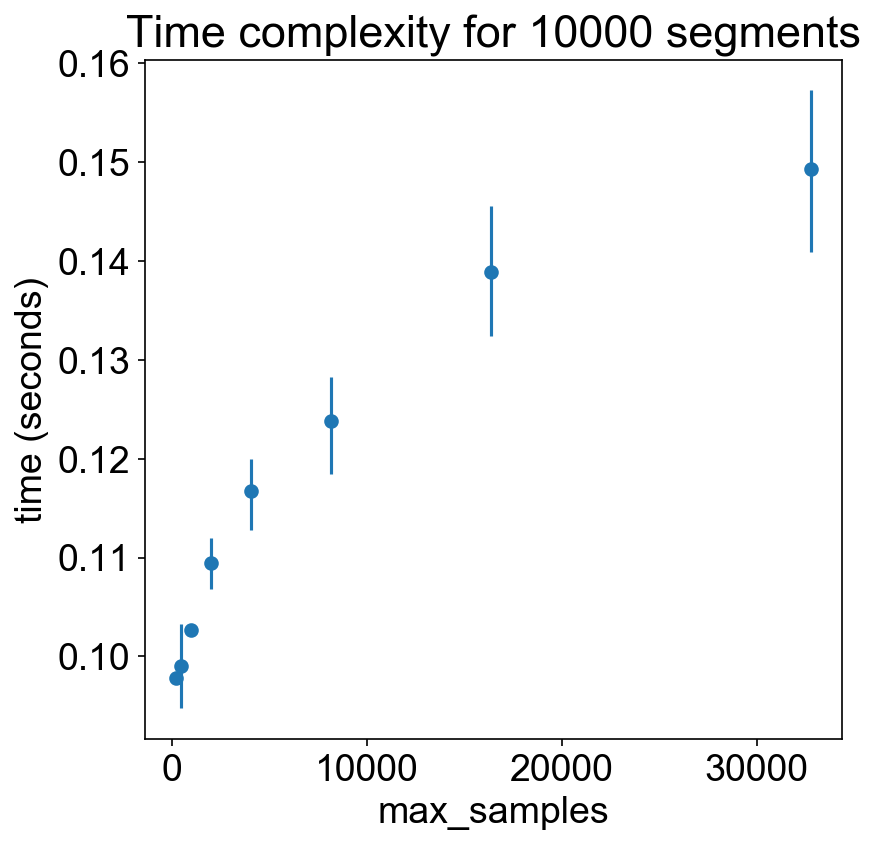

DONE


In [3]:
import time
bins = np.arange(-200, 100, 0.03)
print('Comparing models (clfs) scores:')
print('Above main diagonal: maxima, below main diagonal: median')
indices = list(range(len(clfs)))
dfr = pd.DataFrame(index=indices, columns=indices, data=np.nan)
times = [[] for _ in range(len(clfs))]
for i in indices:
    clf1 = i
    t = time.time()
    scores1 = score_samples(i, bins, False, False)
    t = time.time() - t
    times[i].append(t)
    for j in indices:
        if i >= j:
            continue
        clf2 = j
        t = time.time()
        scores2 = score_samples(j, bins, False, False)
        t = time.time() -t
        times[j].append(t)
        _diffs = np.abs(np.diff(np.array([scores1, scores2]), axis=0))[0]
        dfr.at[i, j] = np.round(np.max(_diffs),2)
        dfr.at[j, i] = np.round(np.median(_diffs),2)

print(dfr.to_string())

import re

with plotparams({'figure.figsize': (6, 6), 'font.size': 18, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    x = labels
    y = np.array([np.nanmean(_) for _ in times])
    yerr = [np.abs(y-[np.nanmin(_) for _ in times]), np.abs(y-[np.nanmax(_) for _ in times])]
    plt.errorbar(x, y, yerr=yerr, marker='o', linestyle='None')
    plt.ylabel('time (seconds)')
    plt.xlabel('max_samples')
    plt.title('Time complexity for %d segments' % len(bins))
    plt.show()


del dfr
print('DONE')



In [4]:
import numpy as np
print('Smoothness (rough estimation: the lower, the scores time series is smoother)')
bins_psd = np.arange(-250, 100, 0.01)
psdvalues = [score_samples(i, bins_psd, False, False) for i in range(len(names))]
for k, val in enumerate(psdvalues):
    prevdiff = val[1] - val[0]
    c = 0
    for i in range(2, len(val)):
        currdiff = val[i] - val[i-1]
        if currdiff*prevdiff < 0:
            c += 1
        prevdiff = currdiff
    score_ = c / float(len(val)-1)
    print("CLF [%d]: %f" % (k, score_))
        

Smoothness (rough estimation: the lower, the scores time series is smoother)
CLF [0]: 0.018143
CLF [1]: 0.031829
CLF [2]: 0.049230
CLF [3]: 0.063973
CLF [4]: 0.080802
CLF [5]: 0.099317
CLF [6]: 0.117575
CLF [7]: 0.141547


Calculating scores on a psd(5seconds) range
Plotting classifiers by n_estimators



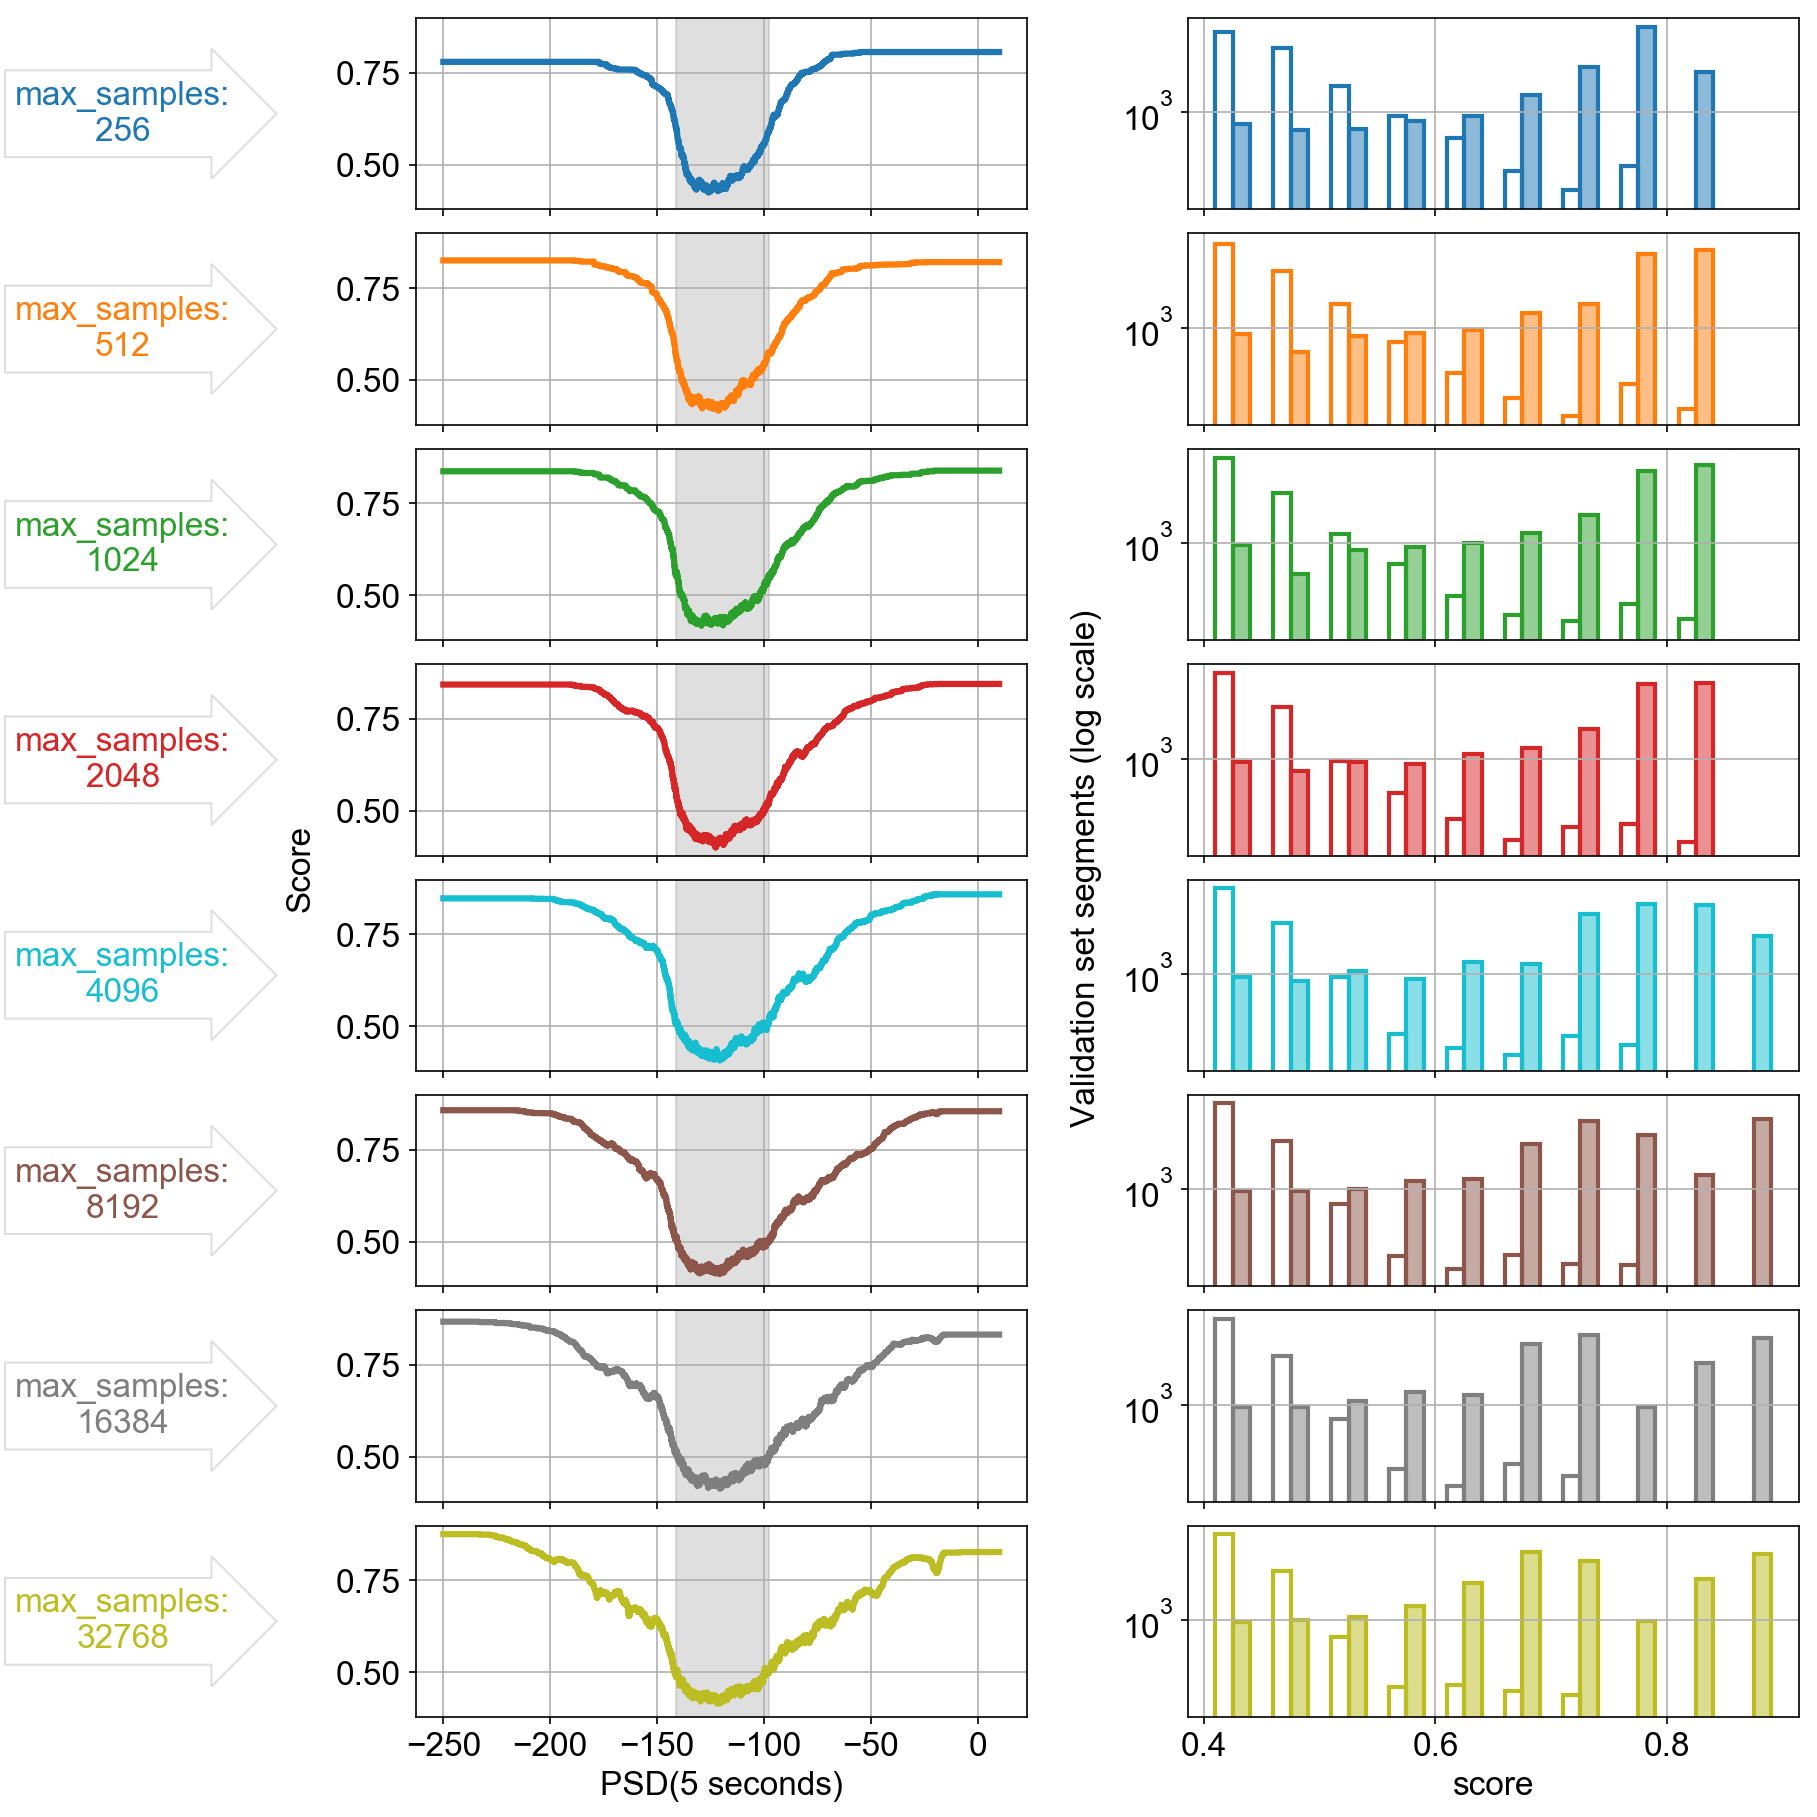

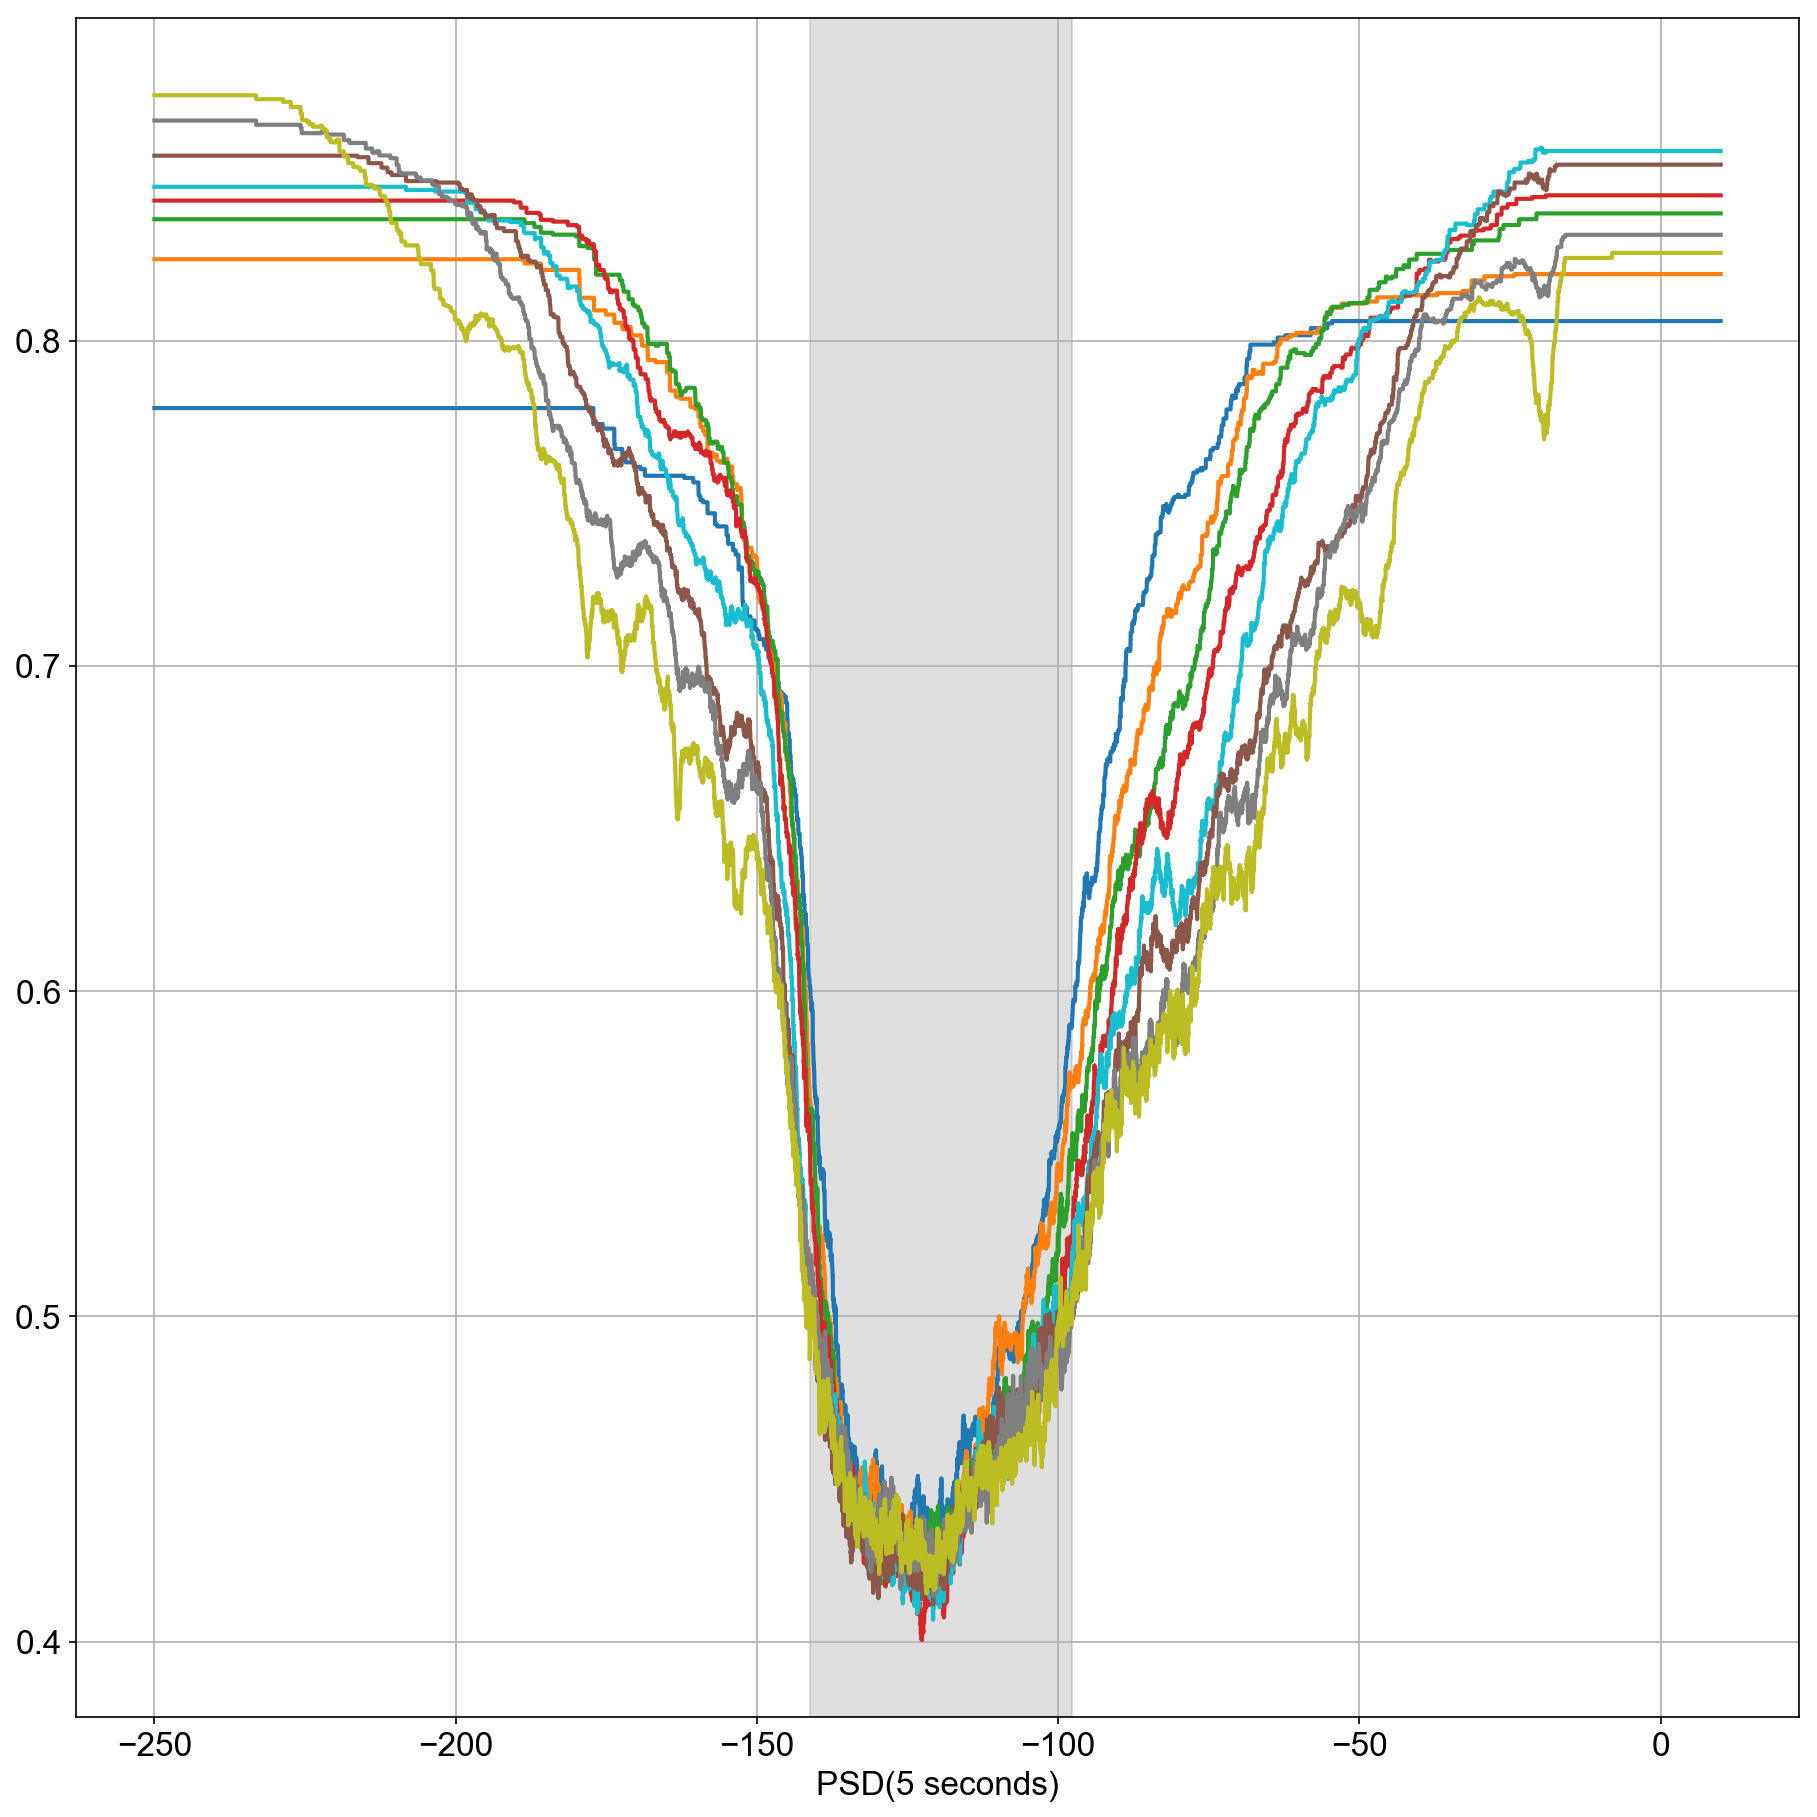

In [5]:
from itertools import chain
from matplotlib.colors import to_rgba

# now plot classifiers:
@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v


from obspy.signal.spectral_estimation import get_nlnm, get_nhnm
def get_petterson_bounds(periods):
    l_periods, l_psd = get_nlnm()
    h_periods, h_psd = get_nhnm()
    periodz = np.log10(periods)
    return np.interp(periodz, np.log10(l_periods[::-1]), l_psd[::-1]), \
        np.interp(periodz, np.log10(h_periods[::-1]), h_psd[::-1]) 
            
            
bins_psd = np.arange(-250, 10, 0.025)
bins_scores = np.arange(0.4, 0.95, 0.05)
bins_score_ticks = bins_scores[::4]

print('Calculating scores on a psd(5seconds) range')
data = [
    [clfs[i], score_samples(i, bins_psd, False, False),
     get_pred_df(i, 0).predicted_anomaly_score.values,  # inliers
     get_pred_df(i, 1).predicted_anomaly_score.values,  # outliers
    ] for i in range(len(clfs))
]


ticks = [0, .25, .5, .75, 1]

def setlim(axes, x=True, y=True):
    minx, maxx, miny, maxy = np.inf, -np.inf, np.inf, -np.inf
    for ax in axes:
        minx = min(ax.get_xlim()[0], minx)
        maxx = max(ax.get_xlim()[1], maxx)
        miny = min(ax.get_ylim()[0], miny)
        maxy = max(ax.get_ylim()[1], maxy)
    for ax in axes:
        if x:
            ax.set_xlim(minx, maxx)
        if y:
            ax.set_ylim(miny, maxy)
    if x and y:
        return minx, maxx, miny, maxy
    elif x:
        return minx, maxx
    elif y:
        return miny, maxy
    else:
        raise ValueError('x and y can not be both False')

        
# The plots below ASSUME there the set of unique n_estimators is 3 for all classifiers involved
# Max samples (the number of lines per plot) can be given here:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:cyan', 'tab:brown', 'tab:gray', 'tab:olive']
assert len(labels) == len(colors)

N = len(colors)

print('Plotting classifiers by n_estimators')
print()

with plotparams({'figure.figsize': (12, 12), 'font.size': 16, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    fig = plt.figure(constrained_layout=True)
    #heights = [2] * (2*len(colors))
    #heights[::2] = [1] * len(colors)
    gs = fig.add_gridspec(N, 5,
                          #height_ratios=heights,
                          width_ratios=[10, 1, 50, 1, 50])
    
    # PLOT MIDDLE PLOT: IT IS A DUMMY PLOT HOLDING ONLY A SHARED y LABEL
    for i, lbl in enumerate(['Score', 'Validation set segments (log scale)']):
        ax = fig.add_subplot(gs[:, 1+2*i])
        ax.set_ylabel(lbl)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_ticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.yaxis.set_label_position("right")

    for j, color in enumerate(colors):
        ax = fig.add_subplot(gs[j, 0])
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_ticklabels([])
        ax.get_yaxis().set_ticks([])
        bbox_props = dict(boxstyle="rarrow", lw=1, fc='white', ec="0.5", alpha=0.25)  # fc='white', ec="0.01",  pad=0.6)
        t = ax.text(0, 0.5, 'max_samples:\n%d' % labels[j], color=color,
                    ha='center', va='center', bbox=bbox_props)
        bb = t.get_bbox_patch()
        # bb.set_boxstyle("rarrow", pad=0.6)
    
#     # PRINT TOP BAR. IT's A PLOT, BUT IT CONTAINS JUST THE LEGENDS
#     data_slice = data
#     titles = set([d[0].n_estimators for d in data_slice])
#     assert len(titles) == 1
#     row_index = 0
#     ax = fig.add_subplot(gs[row_index, :])
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     # comment this if you want to place title and legend:
#     # ax.axis('off')
#     ax.set_xlim([0, 1])
#     ax.set_ylim([0, 1])
# #         ax.text(0.5, 0.5, 'Classifiers with n_estimators=%d and max_samples:' % list(titles)[0],
# #                 ha='left', va='bottom')
#     # dummy bars with width=height=0 just to show the legend
#     for d, color in zip(data_slice, colors):
#         ax.bar([0],[0], color=color, label=str(d[0].max_samples))
#     # place legend: bbox_to_anchor is a 2-tuple (x, y) places the corner of the legend specified
#     # by `loc` at x, y: REMEBER THAT on the Y, 0 is LOWER THAN 1
# #         ax.legend(loc='upper left', ncol=NUM_MAX_SAMPLES*2, bbox_to_anchor=(0, 0.5), frameon=False)
#     # ax.set_title('Classifiers with n_estimators=%d' % list(titles)[0], loc='center')
        
    # left side axes (scores)
    axs_ = []
    for j, color in enumerate(colors):
        ax = fig.add_subplot(gs[j, 2])
        axs_.append(ax)
        ax.axvspan(get_petterson_bounds(5)[0], get_petterson_bounds(5)[1], alpha=0.25, color='gray',
           label='Noise model bounds (Peterson, 93)')
        d = data[j]
        ax.plot(bins_psd, d[1], label='max_samples: %d' % d[0].max_samples, linewidth=3, color=color)
#         for d, color in zip(data_slice, colors):
#             ax.plot(bins_psd, d[1], label='max_samples: %d' % d[0].max_samples, linewidth=3, color=color)
        if j < N-1:
            ax.get_xaxis().set_ticklabels([])
        else:
            ax.set_xlabel('PSD(5 seconds)')
        # ax.set_xlabel('PSD(5 seconds)')
        # ax.set_ylabel('score')
        # ax.legend()
        # ax.set_title('max_samples=%d' % labelz[j])
        ax.grid()
    setlim(axs_, x=True, y=True)

    axs_ = []
    
    data_slice = data
    # testset_scores = [d[2] for d in data_slice]
    for j, color in enumerate(colors):
        ax = fig.add_subplot(gs[j, 4])
        axs_.append(ax)
        testset_inliers_scores = data_slice[j][2]
        testset_outliers_scores = data_slice[j][3]
#         ax.hist(testset_inliers_scores,
#                 bins=bins_scores, label=clf_labels[j],
#                 stacked=False, log=True,
#                 histtype='bar', linewidth=3, align='mid'
#                 , rwidth=0.75, color='white', edgecolor=color,
#                )
#         ax.hist(testset_outliers_scores,
#                 bins=bins_scores, label=clf_labels[j],
#                 stacked=False, log=True,
#                 histtype='bar', linewidth=3, align='mid'
#                 , rwidth=0.75, color=color, edgecolor='white',
#                )
        alphacolor = list(to_rgba(color))
        alphacolor[-1] = 0.5
        ax.hist([testset_inliers_scores, testset_outliers_scores],
                bins=bins_scores, label=[labels[j], labels[j]],
                stacked=False, log=True,
                histtype='bar', linewidth=2, align='mid'
                , rwidth=0.6, color=['white', alphacolor], edgecolor=color
               )
        # ax.set_ylabel('test set segments')
        # ax.set_xlabel('score')
        ax.set_xticks(bins_score_ticks)
        # set xlabel only on bottom plot:
        if j < N-1:
            ax.get_xaxis().set_ticklabels([])
        else:
            ax.set_xlabel('score')
        #ax.get_yaxis().set_visible(False)
        # ax.legend()
        # ax.set_title('max_samples=%d' % labelz[j])
        ax.grid()
    setlim(axs_, x=True, y=True)

    # plt.tight_layout()
    plt.show()
    
    
    
    # show all time series on the same plot
with plotparams({'figure.figsize': (12, 12), 'font.size': 16, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(1, 1)
                            #,
                          #height_ratios=heights,
                          # width_ratios=[10, 1, 50, 1, 50])
    ax = fig.add_subplot(gs[0, 0])
    ax.axvspan(get_petterson_bounds(5)[0], get_petterson_bounds(5)[1], alpha=0.25, color='gray',
           label='Noise model bounds (Peterson, 93)')
    for j, color in enumerate(colors):
        # axs_.append(ax)
        d = data[j]
        ax.plot(bins_psd, d[1], label='%d' % d[0].max_samples, linewidth=2, color=color)
#         for d, color in zip(data_slice, colors):
#             ax.plot(bins_psd, d[1], label='max_samples: %d' % d[0].max_samples, linewidth=3, color=color)
#         if j < N-1:
#             ax.get_xaxis().set_ticklabels([])
#         else:
        ax.set_xlabel('PSD(5 seconds)')
        # ax.set_xlabel('PSD(5 seconds)')
        # ax.set_ylabel('score')
        # ax.legend()
        # ax.set_title('max_samples=%d' % labelz[j])
    ax.grid()
    # ax.legend()

In [6]:
# plotting misclassified channels
import csv

print('Adding event time to prediction dataframes')
timin, tmax = None, None
for i, pred_df in enumerate(pred_dfs):
    assert 'event_time' not in pred_df.columns
    _pred_df = pred_df.merge(allset_test[['allset_test.id', 'dataset_id', 'event_time']],
                             how='left', on=['allset_test.id', 'dataset_id'])
    assert 'event_time' in _pred_df.columns
    natimes = pd.isna(_pred_df.event_time).sum()
    if natimes:
        raise ValueError('%d NAT' % natimes)
    _pred_df = _pred_df.dropna(subset=['event_time'])
    pred_dfs[i] = _pred_df.copy()

    _tmin, _tmax = pd.to_datetime(_pred_df.event_time.min()), pd.to_datetime(_pred_df.event_time.max())
    if i == 0 or _tmin < tmin:
        tmin = _tmin
    if i==0 or _tmax > tmax:
        tmax = _tmax

print('Event times (min, max): %s, %s' % (str(tmin), str(tmax)))

print('Getting station networks and stations (querying source databases)')
_fle = os.path.abspath(os.path.join('.', 'jnconfig.yaml'))
assert os.path.isfile(_fle)
with open(_fle, "r") as _:
    jnconfig = yaml.safe_load(_)

dataset_urls= {
    1: jnconfig['dbpath_new'],
    2: jnconfig['dbpath_me'],
    3: jnconfig['dbpath_chile']
}


station_codes = {}

from stream2segment.process.db import get_session
from stream2segment.io.db.models import Station, Segment, concat, Channel
from stream2segment.io.utils import loads_inv

for dts_id, df in pred_dfs[0].groupby('dataset_id'):  # use just one prediction dataframe, the first
    sess = get_session(dataset_urls[dts_id])
    for (staid, stanet, stasta) in sess.query(Station.id, Station.network, Station.station):
        station_codes[(dts_id, staid)] = "%s.%s" % (stanet, stasta)
    sess.close()


print('DONE')

Adding event time to prediction dataframes
Event times (min, max): 1999-07-07 17:16:11, 2019-08-29 15:07:59
Getting station networks and stations (querying source databases)


/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


DONE


In [7]:
print('Creating dictionaries of predictions on a per station basis with prediction scores mapped to event times')
columns = ['dataset_id', 'station_id', 'cha_id', 'location_code']

data_predicted = {}
from collections import defaultdict

for iii in range(len(clfs)):
    pred_df = get_pred_df(iii, 2)
    for (dts_id, sta_id, cha_id, loc_code), df in pred_df.groupby(columns):

        channel = '%s.%s.%s?' % (station_codes[(dts_id, sta_id)], loc_code, cha_id)
        key = (int(sta_id), int(dts_id), channel)

        if key in data_predicted:
            _plot = data_predicted[key]
        else:
            _plot = {
                'channel': channel,
                'num_segments': len(df),
                'dataset_name': dataset_urls[dts_id][dataset_urls[dts_id].rfind('/')+1:],
                'dataset_id': dts_id,
                'station_id': sta_id,
                'scores': [None for _ in names]
            }
            data_predicted[key] = _plot

        _plot['scores'][iii] = df[['event_time', 'score_samples', 'predicted_anomaly_score']]

print('DONE')

Creating dictionaries of predictions on a per station basis with prediction scores mapped to event times
DONE


Comparing with annotated labels using IF raw scores
Using only csv labels: ['unlabeled (Me unknown)']
Minima and maxima scores (computed on a range of PSD values)
CLF [0]: 0.424345 0.806053
CLF [1]: 0.416421 0.825066
CLF [2]: 0.417877 0.839152
CLF [3]: 0.400199 0.844719
CLF [4]: 0.406651 0.858834
CLF [5]: 0.411211 0.856908
CLF [6]: 0.415198 0.867711
CLF [7]: 0.414773 0.875498

comparing prediction with labels
(2732, 2, 'JP.JWT..BH?'): has outliers with score <= 0.5 in range [2017-02-01, ]
Parsing error in date or scores or ids: Skipping station_id=2863 (dataset_id=2), channel=MC.OLV2..BH?
Parsing error in date or scores or ids: Skipping station_id=1337 (dataset_id=2), channel=ND.MARNC.00.BH?
(1337, 2, 'ND.MARNC.00.BH?'): has outliers with score <= 0.5 in range [2015-09-01, ]
(1010, 2, 'IS.GEM..BH?'): has inliers with score >=0.8 in range [, ]
Parsing error in date or scores or ids: Skipping station_id=372 (dataset_id=2), channel=KO.BAYT..BH?
(538, 2, 'II.RAYN.00.BH?'): has inliers with

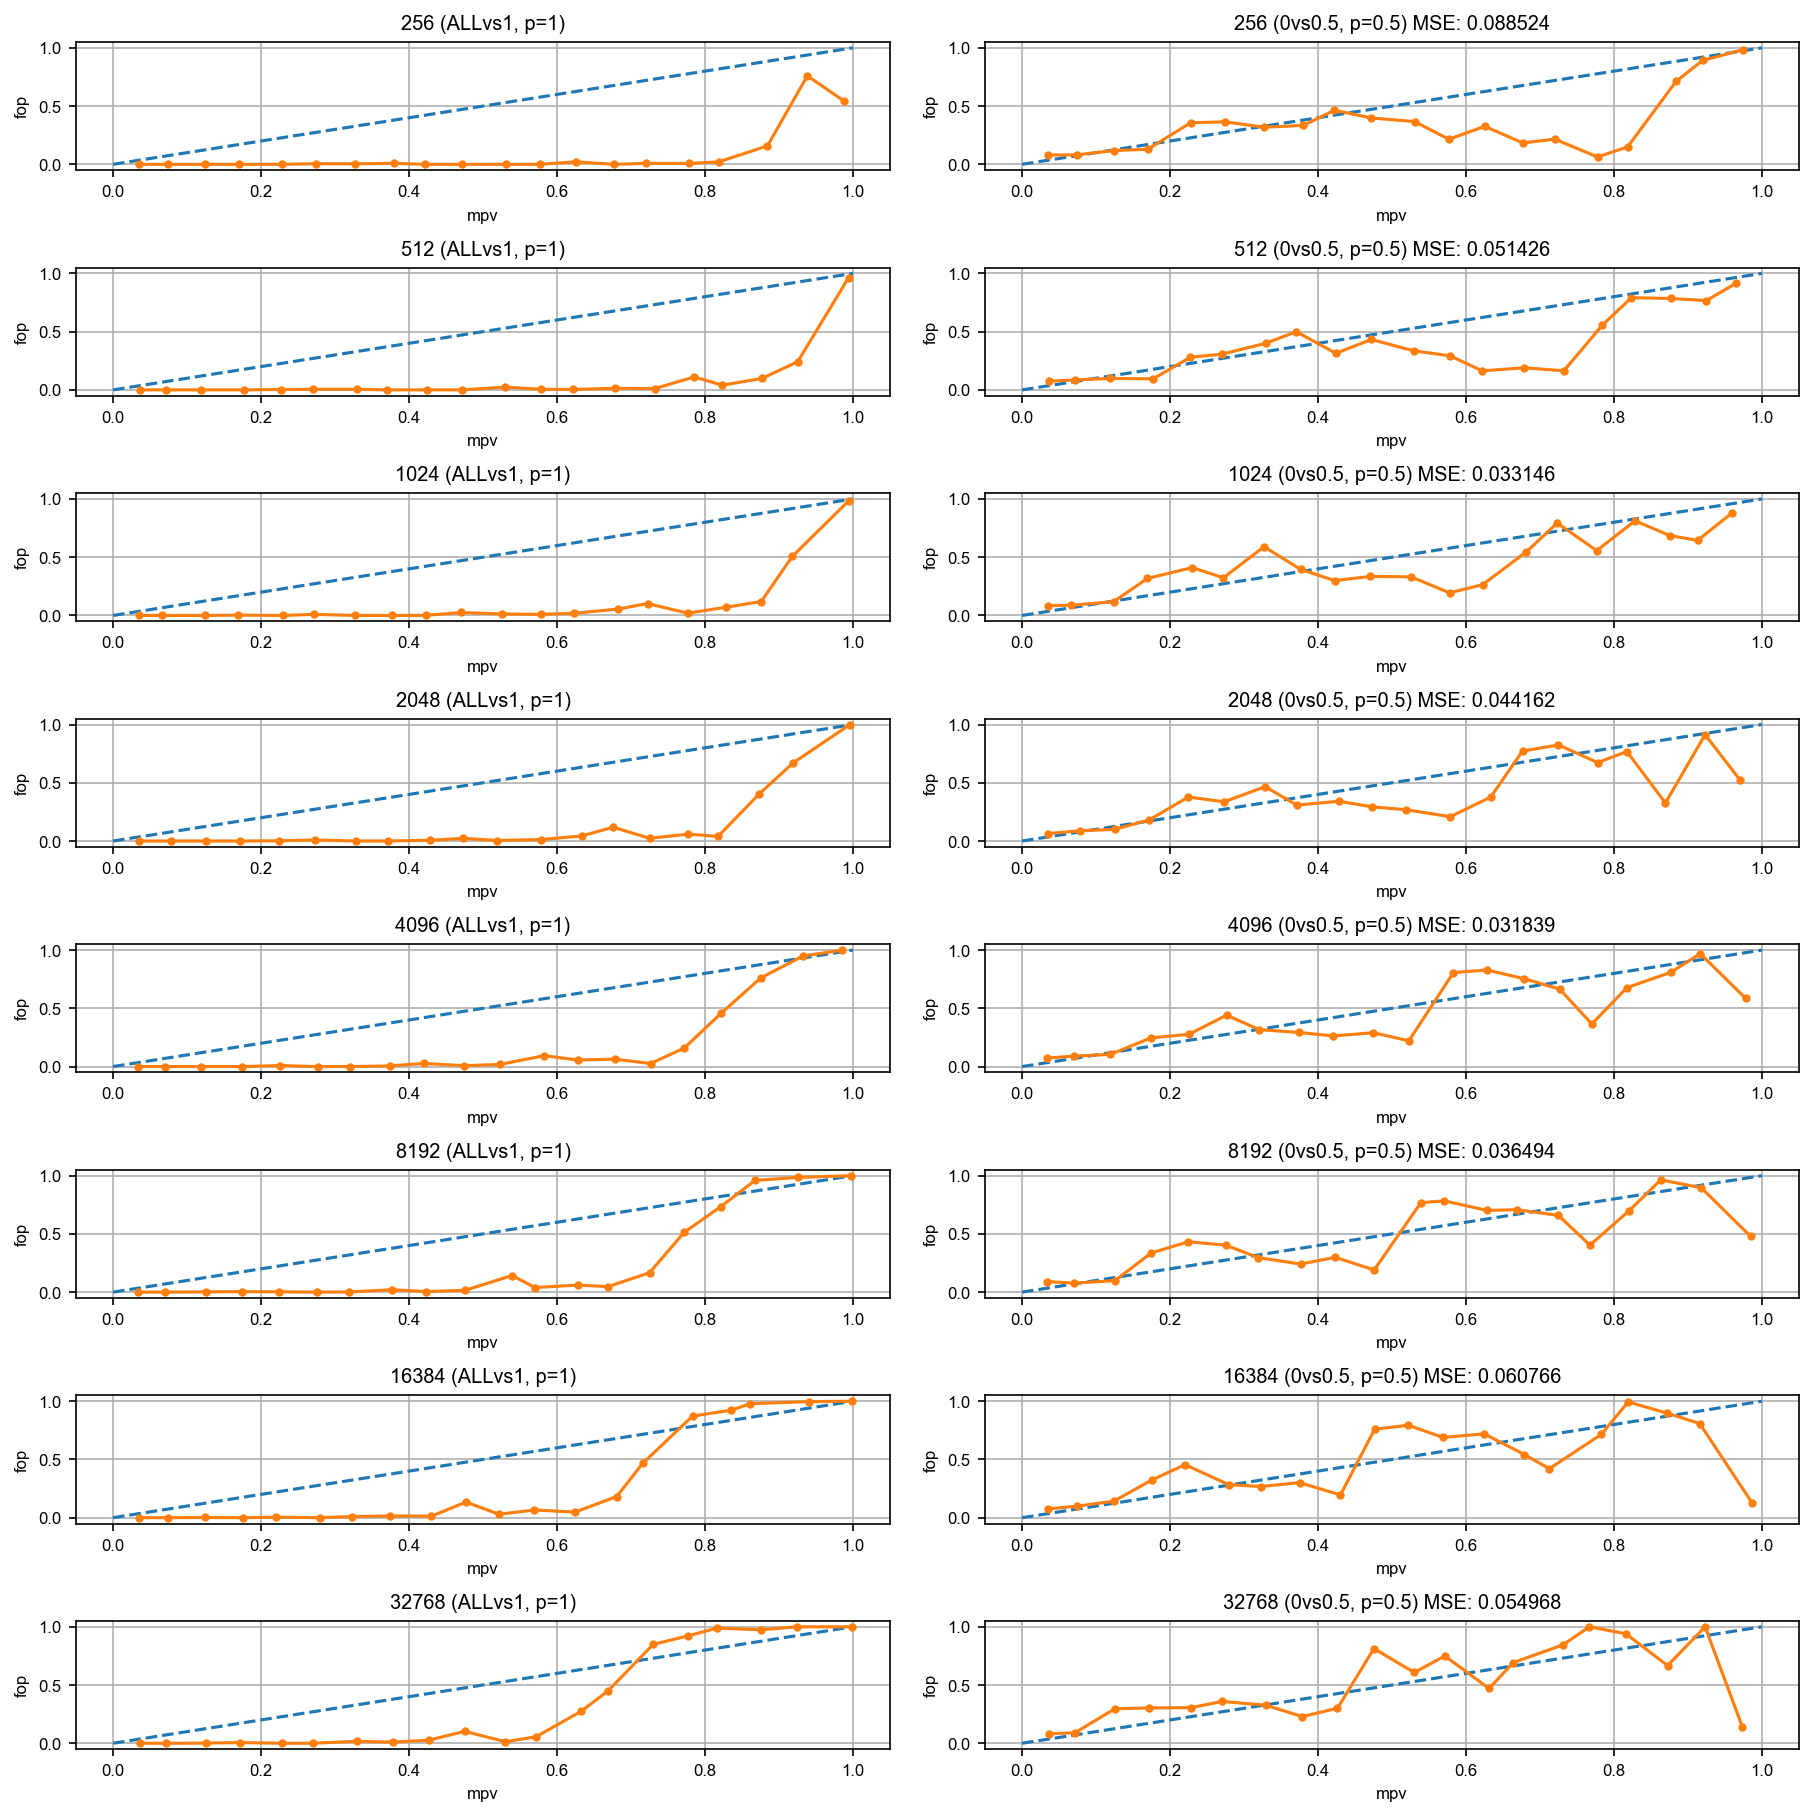


Distributions of different classes


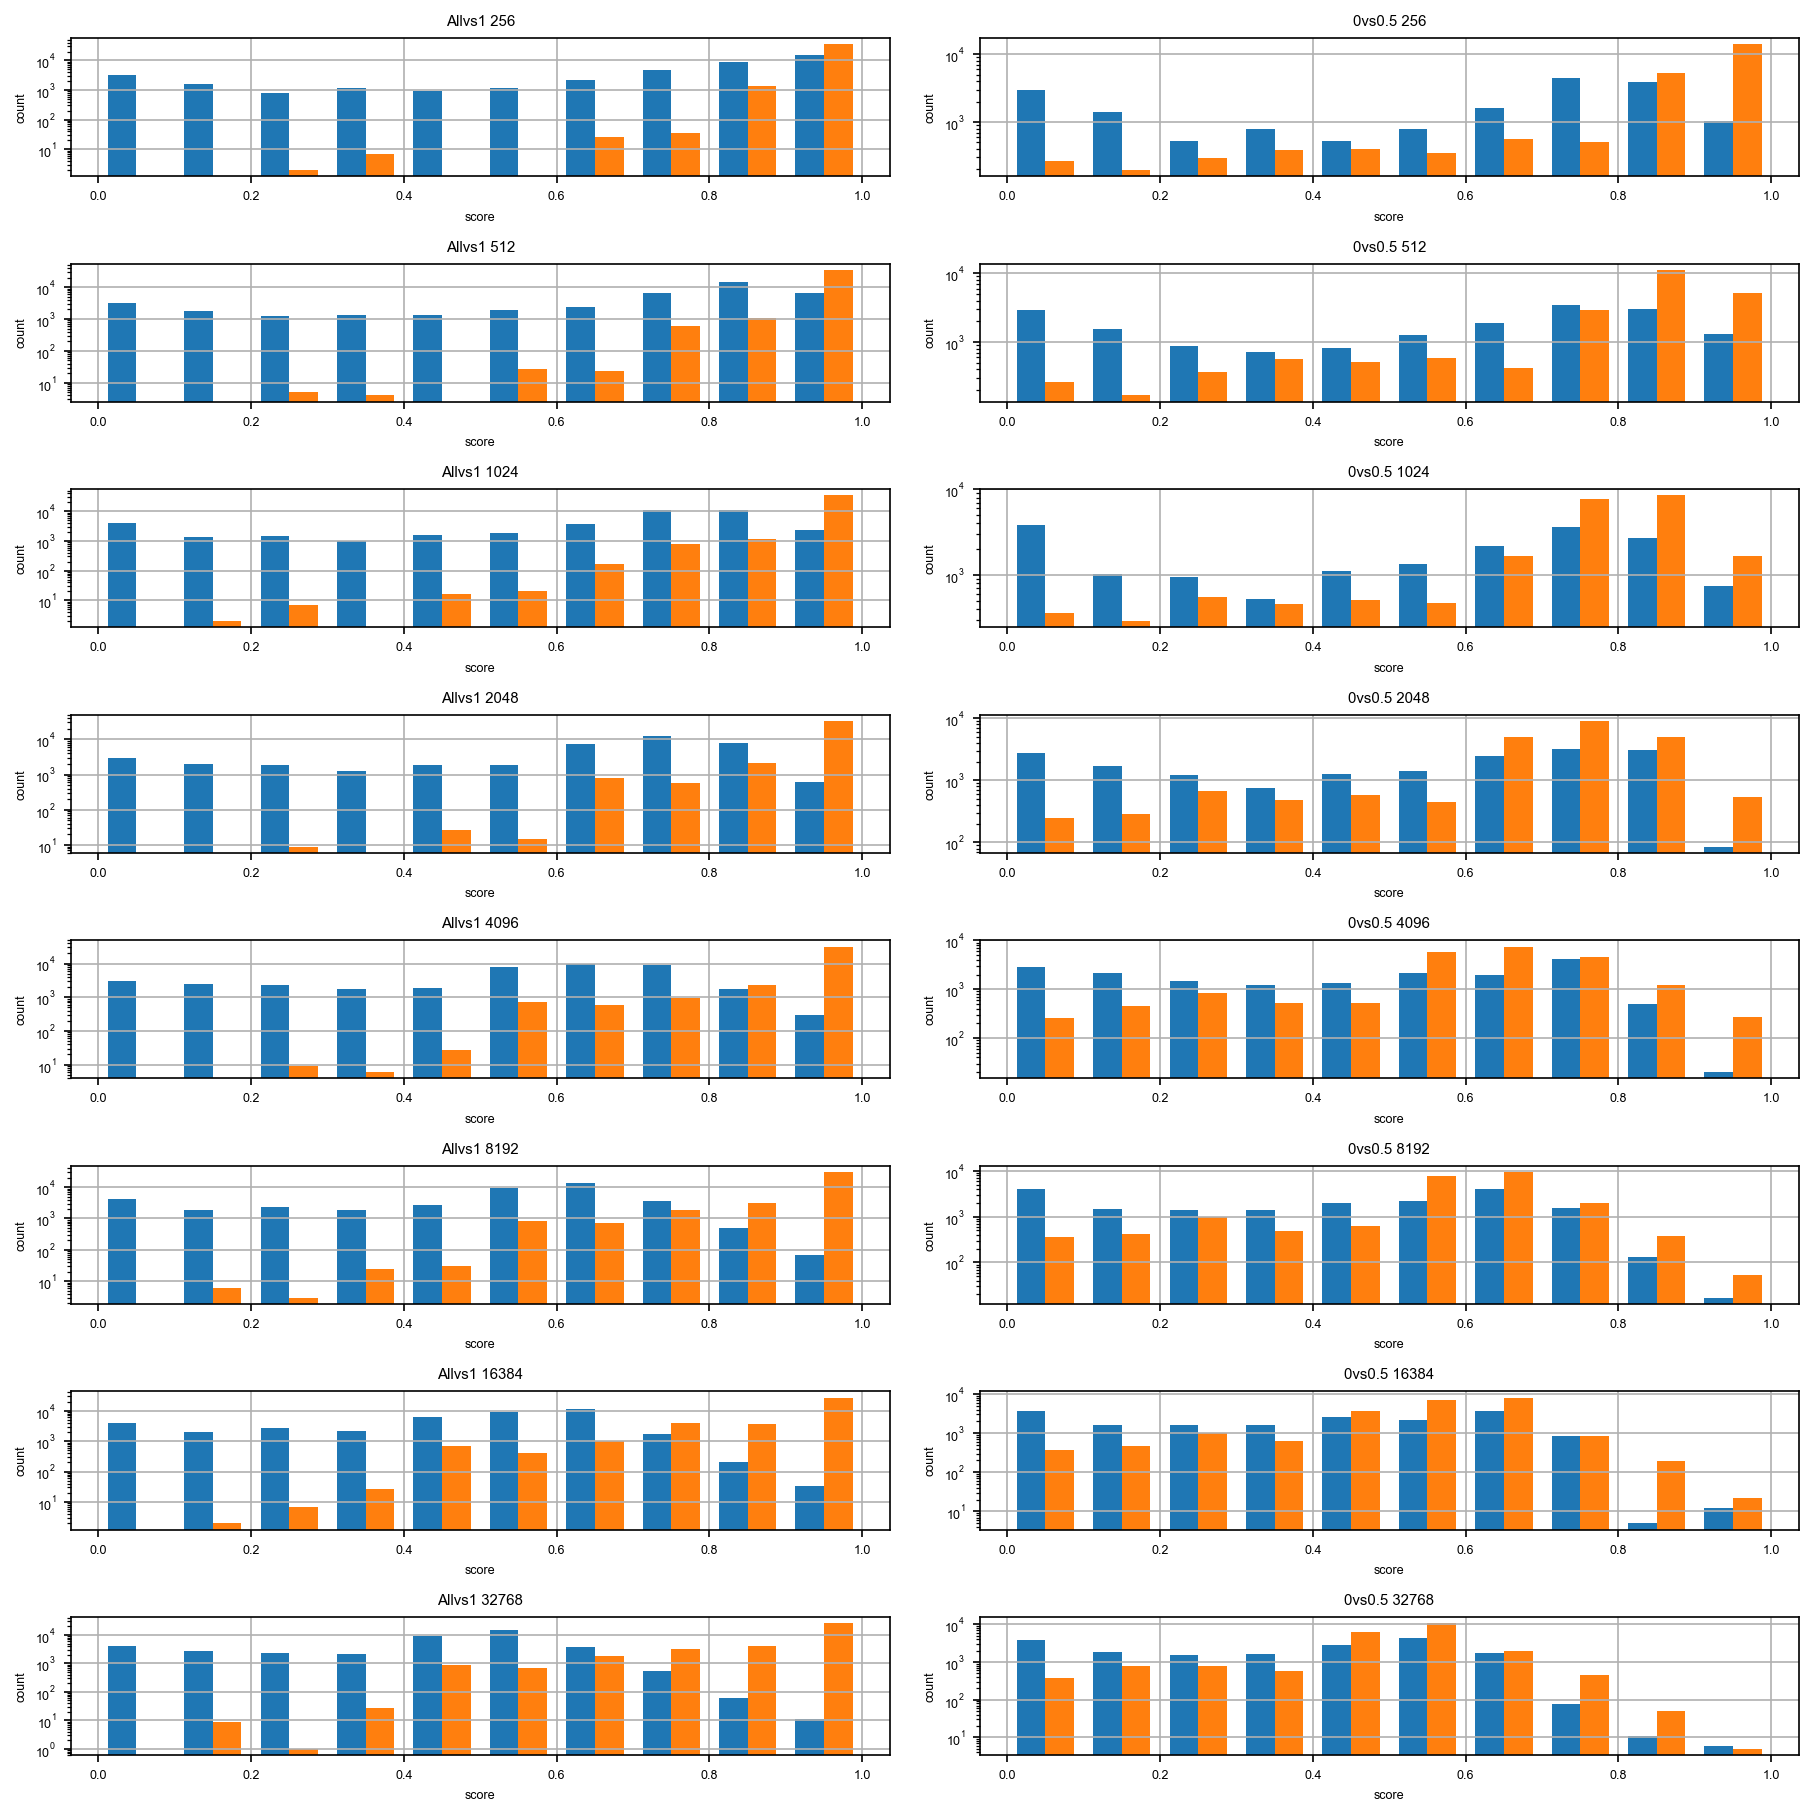

In [17]:
print('Comparing with annotated labels using IF raw scores')
            
from datetime import datetime, timedelta
# datetime.strptime("2010-06-04 21:08:12", "%Y-%m-%d %H:%M:%S")
time0 = tmin - timedelta(days=1)
time1 = tmax + timedelta(days=1)
# time1 = datetime(year=2260, month=1, day=1)  # https://stackoverflow.com/a/37226672

# process only csv rows with this value of 'label':
filter_labels = ['unlabeled (Me unknown)']
print('Using only csv labels: %s' % filter_labels)

min_psd5scores = [np.nanmin(score_samples(i, np.arange(-150, -100, 0.01), False, False)) for i in range(len(clfs))]
max_psd5scores = [np.nanmax(score_samples(i, np.arange(-10000, 100000, 1), False, False)) for i in range(len(clfs))]

print('Minima and maxima scores (computed on a range of PSD values)')
for i in range(len(min_psd5scores)):
    print('CLF [%d]: %f %f' % (i, min_psd5scores[i], max_psd5scores[i]))

print()
print('comparing prediction with labels')
from sklearn.metrics import mean_squared_error as MSE
# map each classifier index to the tuplke (sum_of_mse, number_of_instances)
# this is why MSE multuoutput 'raw_values' seems not to work (it returns the average. WHY???)
mean_squared_errors = [[0, 0] for _ in names]

csvpath = '/Users/riccardo/Nextcloud/rizac_docs/plot.misclassified.final.csv'

scores_df = [[] for _ in range(len(clfs))]

suspicious_annotated_ids = set()

with open(csvpath, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['label'] not in filter_labels:
            continue
        try:
            id_ = (int(row['station_id']), int(row['dataset_id']), row['channel'])
            annotated_score = float(row['score_d'])
            start_time = time0 if not row['start_time'] else datetime.strptime(row['start_time'], "%Y-%m-%d")
            end_time = time1 if not row['end_time'] else datetime.strptime(row['end_time'], "%Y-%m-%d")            
        except ValueError:
            print('Parsing error in date or scores or ids: Skipping station_id=%s (dataset_id=%s), channel=%s' %
                  (row['station_id'], row['dataset_id'], row['channel']))
            continue

        # try to parse also second annotator:
        try:
            annotated_score = 0.5 * (annotated_score * float(row['score_a']))
        except (ValueError, TypeError):
            pass
        
        # fetch data predicted:
        data_pred = data_predicted[id_]
        # print(data_pred)
        zcores = data_pred['scores']
        for clf_idx, _df_ in enumerate(zcores):
            
            # create dataframe with times and predictions:
            _df_with_matching_events = _df_[(_df_.event_time > start_time) & (_df_.event_time < end_time)]
            y_pred = _df_with_matching_events['predicted_anomaly_score'].values
            
            scores_df[clf_idx].append(pd.DataFrame({'y_true': [annotated_score] * len(y_pred), 'y_pred': y_pred}))
            
            # heuristic check (just to confirm the annotations):
            if annotated_score == 1 and np.any(y_pred <= 0.5) and id_ not in suspicious_annotated_ids:
                suspicious_annotated_ids.add(id_)
                print('%s: has outliers with score <= 0.5 in range [%s, %s]' %
                                 (str(id_), str(row['start_time']), str(row['end_time'])))
            if annotated_score == 0 and np.any(y_pred >= 0.8) and id_ not in suspicious_annotated_ids:
                suspicious_annotated_ids.add(id_)
                print('%s: has inliers with score >=0.8 in range [%s, %s]' %
                                 (str(id_), str(row['start_time']), str(row['end_time'])))

# normalize newscores:
for i in range(len(scores_df)):
    scores_df[i] = pd.concat(scores_df[i], sort=False, axis=0, copy=True)

# print()
# print('Metrics (summary):')
# print(metrics.to_string())

from sklearn.metrics import roc_curve, auc
print()
print('Metrics (details):')

auc_scores = pd.DataFrame(index=labels, columns=['AUC[ALLvs1]', 'AUC[0vs0.5]', 'Avg', 'W.Avg'])
f1_scores = pd.DataFrame(index=labels,columns=['F1[ALLvs1]', 'F1[0vs0.5]', 'Avg', 'W.Avg'])
# thresholds_ = [[0,0] for _ in range(len(names))]

ys = []
for i, score_df in enumerate(scores_df):
    y_ = []

    # ALL vs 1
    print('Details for CLF[%d]: max_samples=%d' % (i, labels[i]))
    y_pred = score_df['y_pred'].values
    y_true = (score_df['y_true'] >= 1).values
    assert len(y_pred) == len(y_true)
    auc_, best_th, cm = get_cm(y_true, y_pred)
    print('Class 0: inliers+unknown, Class 1: outliers. Best th: %f. AUC: %f' % (best_th, auc_))
    print(cm.to_string())
    f1_scores.at[labels[i], f1_scores.columns[0]] = cm.values[-1][-1]
    auc_scores.at[labels[i], auc_scores.columns[0]] = auc_
    y_.append([y_true, y_pred])
    
    # 0 vs 0.5
    print('Details for CLF[%d]: max_samples=%d' % (i, labels[i]))
    score_df = score_df[score_df['y_true'] < 1]
    y_pred = score_df['y_pred'].values
    y_true = (score_df['y_true'] >= 0.5).values.astype(int)
    assert len(y_pred) == len(y_true)
    auc_, best_th, cm = get_cm(y_true, y_pred)
    print('Class 0: inliers, Class 1: unknown. Best th: %f. AUC: %f' % (best_th, auc_))
    print(cm.to_string())
    f1_scores.at[labels[i], f1_scores.columns[1]] = cm.values[-1][-1]
    auc_scores.at[labels[i], auc_scores.columns[1]] = auc_
    y_.append([y_true, y_pred])
    
    ys.append(y_)
    
    # print('MEAN F1-score: %f' % np.mean(f1scores))
    print()
    print()

# d['mean'] = d.mean(axis=1)
auc_scores['Avg'] = auc_scores.mean(axis=1)
auc_scores['W.Avg'] = (
    3*auc_scores[auc_scores.columns[0]] +
    2*auc_scores[auc_scores.columns[1]] +
    1*auc_scores[auc_scores.columns[2]]) /6.0
print()
print('AUC scores of different models')
print(auc_scores.to_string())

f1_scores['Avg'] = f1_scores.mean(axis=1)
f1_scores['W.Avg'] = (
    3*f1_scores[f1_scores.columns[0]] +
    2*f1_scores[f1_scores.columns[1]] +
    1*f1_scores[f1_scores.columns[2]]) /6.0
print()
print('F1scores of different models')
print(f1_scores.to_string())


norm_types = [
    'none',
    '[scoremin, scoremax] -> [0, 1]',
    '[pathmin, pathmax] -> [0, 1]'
]

NORM_TYPE = norm_types[2]

def normscores(scores, clf_index):
    i = clf_index
    if NORM_TYPE == norm_types[0]:
        return scores
    if NORM_TYPE == norm_types[1]:
        return (scores - min_psd5scores[i]) / (max_psd5scores[i] - min_psd5scores[i])
    return (np.log2(scores) - np.log2(min_psd5scores[i])) / (np.log2(max_psd5scores[i]) - np.log2(min_psd5scores[i]))

print()
print('PRINTING CALIBRATION. NOTE: scores normalization: %s' % NORM_TYPE)

print()
print('Scores (pseudo) calibration')
from sklearn.calibration import calibration_curve
with plotparams({'figure.figsize': (12, 12), 'font.size': 8, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(len(labels), 2)  #, height_ratios=[1,2,2,2,1,2,2,2,1,2,2,2], width_ratios=[50, 1, 50])
    
    for i, score_df in enumerate(scores_df):
        # all vs 1:
        ax = fig.add_subplot(gs[i, 0])
        y_pred = score_df.y_pred.values
        y_pred2 = np.clip(normscores(y_pred, i), 0, 1)
        y_true = np.copy(score_df.y_true.values)
        y_true[y_true < 1] = 0
        ax.plot([0, 1], [0, 1], linestyle='--')
        fop, mpv = calibration_curve(y_true, y_pred2, n_bins=20)
        ax.plot(mpv, fop, marker='.')
        ax.set_xlabel('mpv')
        ax.set_ylabel('fop')
        ax.set_title('%s (%s)' % (str(labels[i]), 'ALLvs1, p=1'))
        ax.grid()
        
        
        # 0 vs 0.5:
        ax = fig.add_subplot(gs[i, 1])
        score_df = score_df[score_df.y_true<1]
        y_pred = score_df.y_pred.values
        y_pred2 = np.clip(normscores(y_pred, i), 0, 1)
        y_true = np.copy(score_df.y_true.values)
        y_true[y_true >= 0.5] = 1
        ax.plot([0, 1], [0, 1], linestyle='--')
        fop, mpv = calibration_curve(y_true, y_pred2, n_bins=20)
        ax.plot(mpv, fop, marker='.')
        ax.set_xlabel('mpv')
        ax.set_ylabel('fop')
        mse = MSE(mpv, fop)
        ax.set_title('%s (%s) MSE: %f' % (str(labels[i]), '0vs0.5, p=0.5', mse))
        ax.grid()

    plt.show()

print()
print('Distributions of different classes')
with plotparams({'figure.figsize': (12, 12), 'font.size': 6, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    bins = np.arange(0.4, .9, 0.01) if NORM_TYPE == norm_types[0] else np.arange(0, 1.1, 0.1)
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(len(labels), 2)  #, height_ratios=[1,2,2,2,1,2,2,2,1,2,2,2], width_ratios=[50, 1, 50])
    for i, score_df in enumerate(scores_df):
    
        # all vs 1:
        ax = fig.add_subplot(gs[i, 0])
        y_pred = score_df.y_pred.values
        y_pred2 = np.clip(normscores(y_pred, i), 0, 1)
        y_true = np.copy(score_df.y_true.values)
        y_true[y_true < 1] = 0
        ax.hist([y_pred2[y_true<1], y_pred2[y_true>=1]], rwidth=.75, bins=bins, log=True)  # edgecolor='white', linewidth=3, bins=bins)
        ax.set_xlabel('score')
        ax.set_ylabel('count')
        ax.set_title('Allvs1 %s' % (str(labels[i])))
        ax.grid()
        
        
        # 0 vs 0.5:
        ax = fig.add_subplot(gs[i, 1])
        score_df = score_df[score_df.y_true<1]
        y_pred = score_df.y_pred.values
        y_pred2 = np.clip(normscores(y_pred, i), 0, 1)
        y_true = np.copy(score_df.y_true.values)
        y_true[y_true >= 0.5] = 1
        ax.hist([y_pred2[y_true<1], y_pred2[y_true>=1]], rwidth=.75, bins=bins, log=True)  # edgecolor='white', linewidth=3, bins=bins)
        ax.set_xlabel('score')
        ax.set_ylabel('count')
        ax.set_title('0vs0.5 %s' % (str(labels[i])))
        ax.grid()

#        setlim(axs_, x=True, y=True)
    plt.show()

In [9]:
np.hstack([[1,2, 5], [2,3], []])

array([ 1.,  2.,  5.,  2.,  3.])